# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Rescaling, Dropout, Resizing
from keras.layers import RandomFlip, RandomTranslation, RandomRotation, RandomZoom
from keras.models import Sequential
from keras.metrics import F1Score, Precision
from keras.losses import CategoricalFocalCrossentropy
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE, ADASYN, KMeansSMOTE
from imblearn.under_sampling import TomekLinks, RepeatedEditedNearestNeighbours
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.utils import compute_class_weight
from keras.utils import to_categorical
import os
from PIL import Image

2025-04-04 14:50:32.604010: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743771032.623060  293582 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743771032.629116  293582 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-04 14:50:32.648277: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Move images into class folders

In [ ]:
def move_and_separate_images(list_of_folders, df_metadata):
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0
    for folder in list_of_folders:
        for root, dirs, files in os.walk(folder):
            for file in files:
                try:
                    os.makedirs(f'dataset/{df_metadata.loc[file.strip('.jpg'), 'dx']}')
                except:
                    source=os.path.join(root, file)
                    destination=os.path.join('dataset', df_metadata.loc[file.strip('.jpg'), 'dx'], file)
                    os.rename(source,destination)
                    count += 1
                    if count%100 == 0:
                        print(f'{count} images were processed')

In [ ]:
df = pd.read_csv('HAM10000_metadata.csv')

move_and_separate_images(['HAM10000_images_part_1', 'HAM10000_images_part_2'], df)

# Make arrays

In [2]:
def array_from_images(folder, df_metadata, dict_of_labels, h=224, w=224, channels=3):
    # Create an array of images and labels the size of the number of pictures
    nb_files = 0
    for root, dirs, files in os.walk(folder):
        for file in files:
            nb_files += 1
    array = np.zeros(shape=(nb_files, h, w, channels))
    labels = np.zeros(shape=(nb_files,))

    # Check the name and fill array and labels
    df_metadata = df_metadata.set_index('image_id', drop=True)
    count = 0

    for root, dirs, files in os.walk(folder):
        for file in files:
            with Image.open(os.path.join(root, file)) as im:
                array[count,:,:,:] = np.asarray(im.resize((h,w)))
                labels[count] = dict_of_labels[df_metadata.loc[file.strip('.jpg'), 'dx']]
                count += 1
                if count%1000 == 0:
                    print(f'{count} images were processed')
    return array, labels

In [3]:
df = pd.read_csv('HAM10000_metadata.csv')
dict_label = {k:v for k,v in zip(set(df['dx']), range(7))}

size = 64

X, y = array_from_images('dataset/', df, dict_label, h=size, w=size)


1000 images were processed
2000 images were processed
3000 images were processed
4000 images were processed
5000 images were processed
6000 images were processed
7000 images were processed
8000 images were processed
9000 images were processed
10000 images were processed


In [4]:
np.savez_compressed(f'X-{size}x{size}', X, allow_pickle=True)
np.savez_compressed(f'y-{size}x{size}', y, allow_pickle=True)

# Load arrays

In [2]:
X = np.load('X-64x64.npz')['arr_0']
y = np.load('y-64x64.npz')['arr_0']

# Split arrays

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(X, y, stratify=y, test_size=0.2, random_state=38)

del X, y

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, stratify=y_temp, test_size=0.5, random_state=38)

del X_temp, y_temp

# SMOTETOMEK

In [4]:
shape_origin = X_train.shape

X_train = np.reshape(X_train, (shape_origin[0], shape_origin[1]*shape_origin[2]*shape_origin[3]))

smotetomek = SMOTETomek(random_state=38, n_jobs=-1)

X_train, y_train = smotetomek.fit_resample(X_train, y_train)

X_train = np.reshape(X_train, (X_train.shape[0], shape_origin[1], shape_origin[2], shape_origin[3]))



# One Hot Encoding of labels

In [4]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

# Helper functions

In [5]:
def get_earlystopping(patience=10):
    early_stopping = EarlyStopping(
    monitor='val_f1_score',
    patience=patience,
    verbose=1,
    restore_best_weights=True)
    return early_stopping

In [6]:
def plot_learning_curves(model):
    fig, ax = plt.subplots(1,3, figsize=(15,5))
    ax[0].plot(model.history.history['val_f1_score'], label='val_f1_score')
    ax[0].plot(model.history.history['f1_score'], label='f1_score')
    ax[0].legend()
    try:
        ax[1].plot(model.history.history['val_accuracy'], label='val_accuracy')
        ax[1].plot(model.history.history['accuracy'], label='accuracy')
        ax[1].legend()
    except:
        ax[1].plot(model.history.history['val_precision_1'], label='val_precision_1')
        ax[1].plot(model.history.history['precision_1'], label='precision_1')
        ax[1].legend()
    ax[2].plot(model.history.history['val_loss'], label='val_loss')
    ax[2].plot(model.history.history['loss'], label='loss')
    ax[2].legend()
    fig.show;

In [7]:
def get_analysis(model, testX, testy):
    plot_learning_curves(model)
    loss, acc, f1 = model.evaluate(testX, testy)
    print(f'The model gave')
    print(f'Loss: {loss:.2f}')
    print(f'Accuracy: {acc:.2f}')
    print(f'F1 Macro: {f1:.2f}')
    y_pred = model.predict(testX)
    y_res = np.argmax(y_pred, axis=1)
    print(classification_report(testy, y_res))
    return y_pred, y_res

In [8]:
def get_analysis_cat(model, testX, testy):
    plot_learning_curves(model)
    loss, acc, f1 = model.evaluate(testX, testy)
    print(f'The model gave')
    print(f'Loss: {loss:.2f}')
    print(f'Accuracy: {acc:.2f}')
    print(f'F1 Macro: {f1:.2f}')
    predy = model.predict(testX)
    resy = to_categorical(np.argmax(predy, axis=1))
    print(classification_report(testy,resy))
    return predy, resy

In [9]:
def compile_and_train(model, loss, opt, metrics, epochs, patience=None, steps=None):
    model.compile(loss=loss,
                optimizer=opt,
                metrics=metrics)

    model.summary()

    if patience != None:
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            callbacks=[get_earlystopping(patience)],
            steps_per_epoch=steps
            )
    else:
        model.fit(
            X_train,
            y_train,
            epochs=epochs,
            validation_data=(X_val, y_val),
            steps_per_epoch=steps
            )

    return model

# Model

In [12]:
filters = 16

In [13]:
model_020 = Sequential([
    Input(shape=(X_train.shape[1:])),
    Rescaling(1./255),
    RandomFlip('horizontal and vertical'),
    RandomRotation(factor=(-0.3, 0.3)),
    RandomTranslation(height_factor=(-0.3,0.3), width_factor=(-0.3, 0.3)),
    RandomZoom(height_factor=(-0.3,0.3), width_factor=(-0.3, 0.3)),
    Conv2D(filters, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*2, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*4, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(filters, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*2, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*4, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(filters, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*2, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*4, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Conv2D(filters, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*2, kernel_size=3, padding='SAME', activation='relu'),
    Conv2D(filters*4, kernel_size=3, padding='SAME', activation='relu'),
    MaxPooling2D(pool_size=2),
    BatchNormalization(),
    Dropout(0.2),
    Flatten(),
    Dense(filters, activation='relu'),
    Dense(7, activation='softmax')
])

history020 = compile_and_train(model_020,
                               loss=CategoricalFocalCrossentropy(),
                               opt='adam',
                               metrics=['accuracy', F1Score(average='macro')],
                               epochs=200,
                               patience=10)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_1 (RandomFlip)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_1               │ (None, 64, 64, 3)      │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_translation_1            │ (None, 64, 64, 3)      │             0 │
│ (RandomTranslation)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_1 (RandomZoom)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 16, 16, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 138,231 (539.96 KB)

 Trainable params: 137,719 (537.96 KB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/200


E0000 00:00:1743773069.201244  293582 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


251/251 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.6216 - f1_score: 0.1378 - loss: 0.2055 - val_accuracy: 0.6693 - val_f1_score: 0.1171 - val_loss: 0.2042
Epoch 2/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6655 - f1_score: 0.1686 - loss: 0.1408 - val_accuracy: 0.6603 - val_f1_score: 0.1617 - val_loss: 0.1410
Epoch 3/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.6687 - f1_score: 0.1830 - loss: 0.1370 - val_accuracy: 0.6733 - val_f1_score: 0.1448 - val_loss: 0.1990
Epoch 4/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.6666 - f1_score: 0.2087 - loss: 0.1373 - val_accuracy: 0.6703 - val_f1_score: 0.1147 - val_loss: 0.2236
Epoch 5/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.6804 - f1_score: 0.2003 - loss: 0.1303 - val_accuracy: 0.6703 - val_f1_score: 0.1320 - val_loss: 0.1529
Epoch 6/200
251/251 ━━━━━━━━━━━━━━━━━━━━ 12s 48ms/step - accuracy: 0.6837 - f1_score: 0.2268 - loss: 0.1309 - val_accuracy: 0.6723 - val_f1_score: 

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7313 - f1_score: 0.4081 - loss: 0.0932
The model gave
Loss: 0.10
Accuracy: 0.73
F1 Macro: 0.42
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

           0       0.54      0.27      0.36       110
           1       0.30      0.18      0.23        33
           2       0.44      0.38      0.41       111
           3       0.37      0.61      0.46        51
           4       0.00      0.00      0.00        12
           5       0.85      0.91      0.88       670
           6       0.44      0.86      0.59        14

   micro avg       0.73      0.73      0.73      1001
   macro avg       0.42      0.46      0.42      1001
weighted avg       0.71      0.73      0.71      1001
 samples avg       0.73      0.73      0.73      1001



(array([[1.5464771e-01, 5.8777793e-03, 4.3890696e-02, ..., 3.1009387e-02,
         6.4187795e-01, 4.3965201e-03],
        [6.2224217e-02, 3.3079050e-03, 4.6258841e-02, ..., 1.4895059e-02,
         7.5594604e-01, 4.8447587e-02],
        [1.8010043e-01, 2.7320021e-01, 5.6734066e-02, ..., 4.2114452e-02,
         8.7592900e-02, 1.0645932e-03],
        ...,
        [1.7816888e-01, 2.1442219e-03, 6.1744582e-02, ..., 9.3664782e-04,
         7.5479752e-01, 7.2727227e-05],
        [7.7764757e-02, 1.8990502e-03, 6.8029210e-02, ..., 9.1826422e-03,
         7.7612263e-01, 2.8078603e-02],
        [3.4316674e-02, 1.0386953e-03, 9.9617288e-02, ..., 3.5158005e-03,
         6.2675977e-01, 2.2082536e-01]], dtype=float32),
 array([[0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.],
        [0., 0., 0., ..., 0., 1., 0.]]))

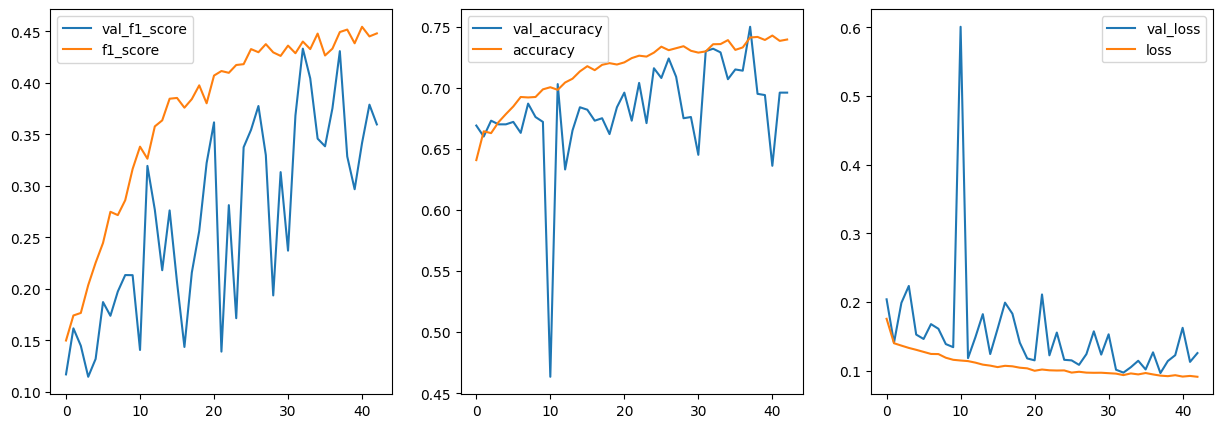

In [14]:
get_analysis_cat(model_020, X_test, y_test)

## Custom loss

In [17]:
import tensorflow as tf
from keras.losses import CategoricalFocalCrossentropy
from keras import backend as K
from keras import ops

def f1macro(y_true, y_pred):
    tp = []
    fp = []
    fn = []
    precision = []
    recall = []
    f1 = []

    cfc = CategoricalFocalCrossentropy()


    for n in range(7):
        tp.append(ops.sum(ops.cast(y_true[:, n] * y_pred[:, n], 'float32'), axis=0))
        fp.append(ops.sum(ops.cast((1 - y_true[:, n]) * y_pred[:, n], 'float32'), axis=0))
        fn.append(ops.sum(ops.cast(y_true[:, n] * (1 - y_pred[:, n]), 'float32'), axis=0))

    for n in range(7):
        precision.append(tp[n] / (tp[n] + fp[n] + K.epsilon()))
        recall.append(tp[n] / (tp[n] + fn[n] + K.epsilon()))

    for n in range(7):
        f1.append(2 * (precision[n] * recall[n]) / (precision[n] + recall[n] + K.epsilon()))

    f1macro = tf.stack(f1)
    f1macroscore = ops.mean(f1macro)

    f1macroscore = tf.where(tf.math.is_nan(f1macroscore), tf.zeros_like(f1macroscore), f1macroscore)

    return cfc + (1 - f1macroscore)